# Forecast Wave Height and Period Simultaneously, further Feature Engineering

# Introduction

This notebook focuses on creating data frames and feature engineering to predict wave height and wave period for same time window, this will be done by refining features.In Time Series using Linear Auto Regression, it could be seen that wave height had and influence on predictin wave period and wave period had an influence on the prediction of wave height. To better understand the importance of this relationship as well as possible forecasting of other components new data frames will be created and the same modelling workflow will be followed.  Furthermore, if the aim is to forecast wave height and wave period simultaneously then current wave height cannot be used to predict wave period and current wave period cannot be used to predict wave height. The rolling data frame will be created by leaving out current feature values relating to both wave height and wave period.  This will include dropping features that may not be present in buoy data or that could not possibly be calculated from buoy data. Features will also be dropped if it is unknown as to weather they incorporate wave height or period inherently. The new rolling data frames will then be used in separate models to forecast wave height and wave period. Forecasting wave height and wave period for the same time frame is done through appropriate feature selection, the strategy is still to use separate models for each. The error differences from the first modelling phase will be evaluated. 

## Methodology

**General Workflow for Notebook**
  1. Create lags 
  2. Columns that incorporate wave height and or wave period will be dropped.
  3. Drop current wave period(VTPS) or wave height(VWHS). Drop other current variables.
  4. Keep relevent lagged varibles.
  5. Add cyclic encoded temporal features.
  6. Add moon phase, as accurate tidal data cannot be obtained for specific location.
  7. Linear/Lasso Regression to see what features are now influencing prediction of wave height.
  8. Use XGBoost/ RF to generate predictions of wave height.

The same workflow for modelling is kept. In this notebook Wave height is modelled first and then wave period. GridSearch is used for optimization in XGBoost and Random Forest with the same time series split for cross validation. The same time train test split is maintained. 

Modelling for wave height and wave period follows this order: 
- Linear Regression
- XGBoost
- Random Forest

A comparison of all models as well as feature analysis based on lasso regression is done in the results section of notebook. 

# Data Dictionary

<details>
  <summary>Data Dictionary</summary>
  
| Field       | Description                                             |
|-------------|---------------------------------------------------------|
| Index       | Date time excluding minutes (used to join df_buoy and df_hind) |
| DEPTH       | Depth in meters                                        |
| VWH         | Characteristic significant wave height (reported by the buoy) (m) |
| VCMX        | Maximum zero crossing wave height (reported by the buoy) (m) |
| VTP         | Wave spectrum peak period (reported by the buoy) (s)   |
| WDIR        | Direction from which the wind is blowing (° True)      |
| WDIR.1      | Estimated Direction from which the wind is blowing (° True)      |
| WSPD        | Horizontal wind speed (m/s)                           |
| WSPD.1      | Estimated wind speed within 10 meters. (m/s)
| WSS         | Horizontal scalar wind speed (m/s)                     |
| GSPD        | Gust wind speed (m/s)                                   |
| GSPD.1      | Documentation not found            |
| ATMS        | Atmospheric pressure at sea level (mbar)               |
| DRYT        | Dry bulb temperature (air temperature) (°C)            |
| SSTP        | Sea surface temperature (°C)                           |
| WD          | Wind Direction (deg from which wind is blowing (° True)) |
| WS          | Wind Speed (m/s)                                       |
| ETOT        | Total Variance of Total Spectrum (m^2)                |
| TP          | Peak Spectral Period of Total Spectrum (sec)           |
| VMD         | Vector Mean Direction of Total Spectrum (deg to which) |
| ETTSea      | Total Variance of Primary Partition (m^2)             |
| TPSea       | Peak Spectral Period of Primary Partition (sec)        |
| VMDSea      | Vector Mean Direction of Primary Partition (deg to which) |
| ETTSw       | Total Variance of Secondary Partition (m^2)           |
| TPSw        | Peak Spectral Period of Secondary Partition (sec)      |
| VMDSw       | Vector Mean Direction of Secondary Partition (deg to which) |
| MO1         | First Spectral Moment of Total Spectrum (m^2/s)       |
| MO2         | Second Spectral Moment of Total Spectrum (m^2/s^2)    |
| HS          | Significant Wave Height (m)                            |
| DMDIR       | Dominant Direction (deg to which)                       |
| ANGSPR      | Angular Spreading Function                             |
| INLINE      | In-Line Variance Ratio                                 |



In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import decimal
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
df=pd.read_csv('../Data/df_daily_imputed.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9902 entries, 1988-11-22 to 2016-01-01
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LATITUDE   9902 non-null   float64
 1   LONGITUDE  9902 non-null   float64
 2   DEPTH      9902 non-null   float64
 3   VWH$       9902 non-null   float64
 4   VCMX       9902 non-null   float64
 5   VTP$       9902 non-null   float64
 6   WDIR       9902 non-null   float64
 7   WSPD       9902 non-null   float64
 8   GSPD       9902 non-null   float64
 9   WDIR.1     9902 non-null   float64
 10  WSPD.1     9902 non-null   float64
 11  GSPD.1     9902 non-null   float64
 12  ATMS       9902 non-null   float64
 13  DRYT       9902 non-null   float64
 14  SSTP       9902 non-null   float64
 15  YEAR       9902 non-null   float64
 16  WD         9902 non-null   float64
 17  WS         9902 non-null   float64
 18  ETOT       9902 non-null   float64
 19  TP         9902 non-null   float64
 20

# Wave Height

### Set up Dataframe(s)

**Step 1, Lag features**

In [4]:
# convert directions(degrees North) into radians
columns_to_convert = ['VMD', 'VMDSea', 'VMDSw', 'WD', 'WDIR', 'WDIR.1']

# Convert specified columns to radians
df[columns_to_convert] = np.radians(df[columns_to_convert])

In [5]:
# Define lags for different time intervals
lags = {'1_day': 1, '1_week': 7, '1_month': 30, '3_month': 90}


# Create a new DataFrame to avoid modifying the original DataFrame in place
new_df = pd.DataFrame()

# Create lags
for column in df.select_dtypes(include='number').columns:
    # Create lags for different time intervalsa
    for lag_name, lag_value in lags.items():
        new_df[f'{column}_lag_{lag_name}'] = df[column].shift(lag_value)


# Combine the new features with the original DataFrame
features_df = pd.concat([df, new_df], axis=1)

# Drop rows with null values
features_df = features_df.dropna()

# Display the modified DataFrame
print(features_df.head())


               LATITUDE  LONGITUDE  DEPTH      VWH$      VCMX       VTP$  \
Datetime_buoy                                                              
1989-02-20        48.83      126.0   73.0  2.000417  3.683333  12.922500   
1989-02-21        48.83      126.0   73.0  2.281739  3.926087  13.330435   
1989-02-22        48.83      126.0   73.0  2.645000  4.691667  10.620833   
1989-02-23        48.83      126.0   73.0  2.488750  4.337500  10.010000   
1989-02-24        48.83      126.0   73.0  2.564583  4.475000  12.950833   

                   WDIR       WSPD       GSPD    WDIR.1  ...  \
Datetime_buoy                                            ...   
1989-02-20     2.070397   9.537500  11.558333  1.914772  ...   
1989-02-21     2.057971  10.847826  13.182609  1.891026  ...   
1989-02-22     2.600541   8.416667  10.287500  2.431098  ...   
1989-02-23     2.953970   5.193750   6.987500  2.781618  ...   
1989-02-24     1.845686   5.983333   7.516667  1.693697  ...   

               DMD

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/3227811285.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_lag_{lag_name}'] = df[column].shift(lag_value)
/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/3227811285.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_lag_{lag_name}'] = df[column].shift(lag_value)
/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/3227811285.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is us

In [59]:
#drop features for waveheight dataframe: 
col_to_drop = ['VCMX','HS','ETTSea','ETOT','ETTSw','VTP$','TPSea','TP','TPSw','TPSea']
wh_df = features_df.drop(columns=col_to_drop)

In [60]:
wh_df.index = pd.to_datetime(wh_df.index)

In [61]:
#Create cyclical encoded features for month, season, and week
wh_df['month_sin'] = np.sin(2 * np.pi * wh_df.index.month / 12)
wh_df['month_cos'] = np.cos(2 * np.pi * wh_df.index.month / 12)

#Assume seasons are defined as quarters (1-4)
wh_df['season_sin'] = np.sin(2 * np.pi * wh_df.index.month % 12 / 4)
wh_df['season_cos'] = np.cos(2 * np.pi * wh_df.index.month % 12 / 4)

wh_df['week_sin'] = np.sin(2 * np.pi * wh_df.index.strftime('%U').astype(int) / 52)  # Assuming 52 weeks in a year
wh_df['week_cos'] = np.cos(2 * np.pi * wh_df.index.strftime('%U').astype(int) / 52)


/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/1553120114.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/1553120114.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/1553120114.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [62]:
wh_df.shape

(9812, 162)

In [63]:
# add moonphase as a column (Code for moonphase taken from kaggle: https://www.kaggle.com/competitions/m5-forecasting-accuracy/discussion/154776)
def get_moon_phase(d):  # 0=new, 4=full; 4 days/phase
    diff = d - datetime(2001, 1, 1)
    days = decimal.Decimal(diff.days) + (decimal.Decimal(diff.seconds) / decimal.Decimal(86400))
    lunations = decimal.Decimal("0.20439731") + (days * decimal.Decimal("0.03386319269"))
    phase_index = math.floor((lunations % decimal.Decimal(1) * decimal.Decimal(8)) + decimal.Decimal('0.5'))
    return int(phase_index) & 7

In [64]:
wh_df['moon_phase'] = wh_df.index.map(get_moon_phase)

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/385246117.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [65]:
#cyclic encode the moonphase as it is ordinal, then drop moon phase
wh_df['moon_phase_sin'] = np.sin(2 * np.pi * wh_df['moon_phase'] / 8)
wh_df['moon_phase_cos'] = np.cos(2 * np.pi * wh_df['moon_phase'] / 8)

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/1094069381.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/1094069381.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [66]:
wh_df=wh_df.drop('moon_phase', axis=1)

In [67]:
wh_df.shape

(9812, 164)

### Linear Regression

In [68]:
#split on date for train and test
split_point = '2006-01-01'
#filter data on split point
train_wh= wh_df.index < split_point
test_wh = wh_df.index >= split_point

In [69]:
#define X and y
X_train_wh = wh_df[train_wh].drop(['VWH$'],axis=1)
y_train_wh = wh_df[train_wh]['VWH$']

X_test_wh = wh_df[test_wh].drop(['VWH$'], axis=1)
y_test_wh = wh_df[test_wh]['VWH$']

In [70]:
X_train_wh.shape

(6159, 163)

In [71]:
#PCA and Scale
pca = PCA(n_components=0.95)
scaler = StandardScaler()
#fit and transform to train X, transform test X
X_train_wh_pca = pca.fit_transform(scaler.fit_transform(X_train_wh))
X_test_wh_pca = pca.transform(scaler.transform(X_test_wh))

MSE Wave Height: 0.3071681148403342
MAE Wave Height: 0.39169400564231205


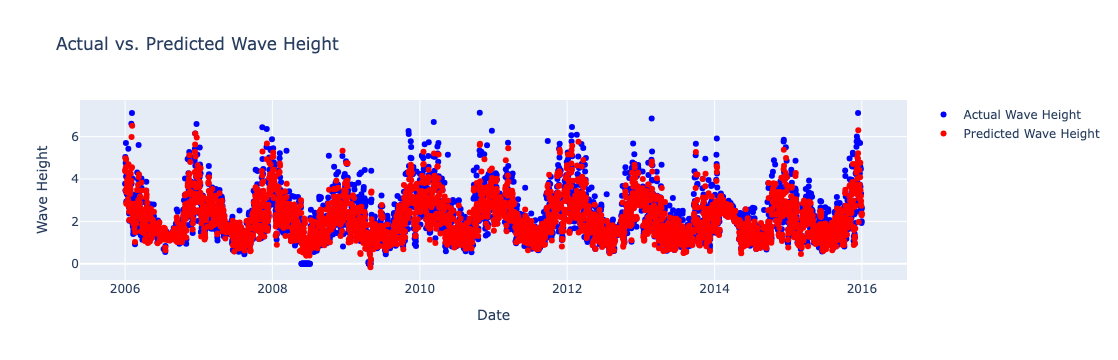

In [73]:
#Linear Regression
model_linreg_wh = LinearRegression()
model_linreg_wh.fit(X_train_wh_pca, y_train_wh)

#Predict
y_wh_pred = model_linreg_wh.predict(X_test_wh_pca)

#Calculate MSE and MAE
mse_wh = mean_squared_error(y_test_wh,y_wh_pred)
mae_wh = mean_absolute_error(y_test_wh,y_wh_pred)
#Print MSE and MAE
print("MSE Wave Height:", mse_wh)
print("MAE Wave Height:", mae_wh)

#Plot Linear Reg. with predictions and acutal values
#plt.figure(figsize=(15, 6))
#plt.scatter(features_df.index[test_wh], y_test_wh, label='Actual Wave Height', color='blue')
#plt.scatter(features_df.index[test_wh], y_wh_pred, label='Predicted Wave Height', color='red')
#plt.xlabel('Date')
#plt.ylabel('Wave Height')
#plt.legend()
#plt.title('Actual vs. Predicted Wave Height')
#plt.show()

#Scatter plot for Actual Wave Height
actual_trace = go.Scatter(x=features_df.index[test_wh], y=y_test_wh, mode='markers', name='Actual Wave Height', marker=dict(color='blue'))

#Scatter plot for Predicted Wave Height
predicted_trace = go.Scatter(x=features_df.index[test_wh], y=y_wh_pred, mode='markers', name='Predicted Wave Height', marker=dict(color='red'))

#Create the layout
layout = go.Layout(
    title='Actual vs. Predicted Wave Height',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Wave Height'),
    showlegend=True
)

#Create figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)

#Show 
fig.show()


In [74]:
scaler = StandardScaler()
X_train_lasso = scaler.fit_transform(X_train_wh)
X_test_lasso = scaler.transform(X_test_wh) 

In [75]:
#use for loop to optimize for alpha value 
alpha_vals= [0.001,0.01,0.1,1,10]

best_alpha= None
best_mse = float('inf')

#iterate through alpha values
for alpha in alpha_vals:
    #fit lasso model
    lasso =Lasso(alpha=alpha)
    lasso.fit(X_train_lasso, y_train_wh)

    #predict
    y_pred_lasso = lasso.predict(X_test_lasso)
    #MSE
    mse = mean_squared_error(y_test_wh,y_pred_lasso)

    #check if current alpha gives a better mse
    if mse < best_mse:
        best_mse = mse
        best_alpha =alpha

print(f'Best Alpha:{best_alpha}')
print(f'Best MSE: {best_mse}')

final_lasso = Lasso(alpha=best_alpha)
final_lasso.fit(X_train_lasso, y_train_wh)


/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.065e+00, tolerance: 6.911e-01



Best Alpha:0.001
Best MSE: 0.22766019058253356


/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.065e+00, tolerance: 6.911e-01



Lasso(alpha=0.001)

Feature: WSPD.1, Coefficient: -1.8245109828935384
Feature: GSPD.1, Coefficient: 1.7873506843905675
Feature: WSPD, Coefficient: -1.3310786978866636
Feature: MO2, Coefficient: 1.3193647286999612
Feature: GSPD, Coefficient: 0.9761087695176517
Feature: VTP$_lag_1_day, Coefficient: 0.9645639724041037
Feature: WSPD_lag_1_day, Coefficient: 0.6962054170404564
Feature: MO2_lag_1_day, Coefficient: -0.5969205288292309
Feature: MO1, Coefficient: -0.5846485211349545
Feature: GSPD_lag_1_day, Coefficient: -0.5771988682833384
Feature: WS, Coefficient: -0.4661541438170187
Feature: HS_lag_1_day, Coefficient: 0.3905967191823733
Feature: week_cos, Coefficient: 0.3414614639220673
Feature: WSPD_lag_1_month, Coefficient: 0.33518358946629084
Feature: GSPD_lag_1_month, Coefficient: -0.2950722022068294
Feature: MO2_lag_1_week, Coefficient: -0.22904693274756566
Feature: YEAR, Coefficient: -0.2176844660122315
Feature: month_sin, Coefficient: 0.20600958785338055
Feature: GSPD.1_lag_1_month, Coefficient: -0.2031312

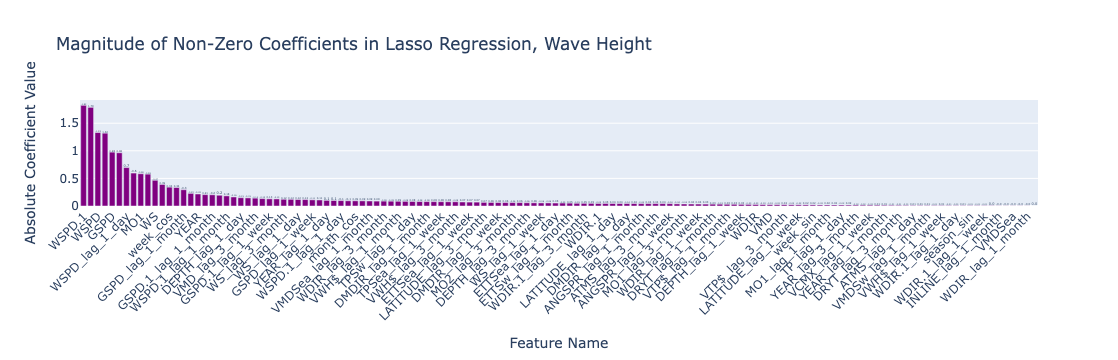

In [170]:
coefficients_lasso_wh = final_lasso.coef_
# Assuming X_train1 and X_test1 are your original feature matrices with named columns
original_feature_names_wh = X_train_wh.columns.tolist()

# Identify non-zero coefficients and their corresponding feature names
non_zero_indices = np.nonzero(coefficients_lasso_wh)[0]
non_zero_feature_names = [original_feature_names_wh[i] for i in non_zero_indices]
non_zero_coefficients = coefficients_lasso_wh[non_zero_indices]

# Create a list of tuples containing feature names and coefficients
feature_coefficient_pairs_wh = list(zip(non_zero_feature_names, non_zero_coefficients))

# Sort the list based on the absolute values of coefficients in descending order
sorted_feature_coefficient_pairs_wh = sorted(feature_coefficient_pairs_wh, key=lambda x: abs(x[1]), reverse=True)

# Print the sorted list
for feature, coefficient in sorted_feature_coefficient_pairs_wh:
    print(f'Feature: {feature}, Coefficient: {coefficient}')

# Plotly bar plot for non-zero feature names and coefficients
fig = go.Figure()

fig.add_trace(go.Bar(
    x=[pair[0] for pair in sorted_feature_coefficient_pairs_wh],
    y=[abs(pair[1]) for pair in sorted_feature_coefficient_pairs_wh],
    marker_color='purple',
    text=[round(pair[1], 2) for pair in sorted_feature_coefficient_pairs_wh],
    textposition='outside'
))

fig.update_layout(
    title='Magnitude of Non-Zero Coefficients in Lasso Regression, Wave Height',
    xaxis_title='Feature Name',
    yaxis_title='Absolute Coefficient Value',
    xaxis_tickangle=-45,
    showlegend=False
)

fig.show()


### Ensemble Learning

In [41]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import time
from sklearn.metrics import make_scorer

import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor



In [24]:
#Use function for grid search
def run_grid_search(X_train, y_train, param_grid, pipeline, scoring_metric, identifier):
    """
    Run a grid search with the specified parameters.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - param_grid: Parameter grid for the grid search
    - pipeline: pipeline object
    - scoring_metric: Scikit-learn scoring metric
    - identifier: Identifier for iteration of Gridsearch'

    Returns:
    - grid_search: Fitted GridSearchCV object 
    -resluts of cross validation in terms of best params, best score (validation set)
    - time it took to run GridSearch
    """
    #initiate timer module
    start_time = time.time()
    #time series cv
    tscv = TimeSeriesSplit(n_splits=3)
    # Set up the scoring metric
    scoring = scoring_metric

    # Instantiate GridSearchCV with 5-fold cross-validation, n_jobs=3, and specified scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=scoring, n_jobs=3)

    # Fit and run grid search
    grid_search.fit(X_train, y_train)

    #end timer
    end_time = time.time()
    elapsed_time = end_time - start_time
    
     # Store the results (hyperparameters and scores)
    results_list.append({
        'identifier': identifier,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'elapsed_time': elapsed_time
    })
    
    # Print the best parameters with the identifier
    print(f"Best Parameters for {identifier}: {grid_search.best_params_}")

    # Print the best score on the validation sets, 
    #.best_score_ is attribute of GridSearch CV that accesses best validation score(score specified in GS)
    print(f"Best {scoring_metric} Score for {identifier}: {grid_search.best_score_}")
    # Print the elapsed time
    print(f"Elapsed Time for {identifier}: {elapsed_time} seconds")

    return grid_search


In [26]:
#store results in list
results_list =[]

In [32]:
def evaluate_model(best_model, X_test, y_test):
    """
    Evaluate the performance of a given model on the test set.

    Parameters:
    - best_model: The best model obtained from grid search or elsewhere.
    - X_test: The feature matrix for the test set.
    - y_test: The true labels for the test set.

    Returns:
    - y_pred: The model predictions on the test set.
    - mse: Mean Squared Error.
    - mae: Mean Absolute Error.
    """

    # Predict using the best model
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print metrics
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    # Return predictions, mse, and mae
    return y_pred, mse, mae

### XGBoost

XGBoost will be used to forecast wave height for 1 day window. Model will be optimized using gridsearch. 

In [77]:
#pipeline object
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb_model',xgb.XGBRegressor(objective ='reg:squarederror',random_state=42))
])

**XGBoost Wave Height, Gridsearch 1, Identifier: 'xg_base_opt_wh'**

First Gridsearch will be used

In [78]:
#Param Grid
param_grid_gbtree = {
    'xgb_model__booster': ['gbtree'],
    'xgb_model__learning_rate': [0.01, 0.1, 0.2],
    'xgb_model__max_depth': [3, 5, 7],
    'xgb_model__n_estimators': [50, 100, 200],
}

# Param grid for gblinear booster
param_grid_gblinear = {
    'xgb_model__booster': ['gblinear'],
    'xgb_model__learning_rate': [0.01, 0.1, 0.2],
    'xgb_model__reg_alpha': [0, 0.1, 0.5],
}


base_param_grid =[param_grid_gbtree, param_grid_gblinear]

In [79]:
scoring_metric = 'neg_mean_squared_error'
results_gridsearch = run_grid_search(X_train_wh, y_train_wh, base_param_grid, xgb_pipeline, scoring_metric, 'xg_base_opt_wh')

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Parameters for xg_base_opt_wh: {'xgb_model__booster': 'gbtree', 'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 5, 'xgb_model__n_estimators': 100}
Best neg_mean_squared_error Score for xg_base_opt_wh: -0.2413715085698729
Elapsed Time for xg_base_opt_wh: 40.725749015808105 seconds


In [80]:
#evaluate best model 
y_pred_xg_wh1, mse_xg_wh1, mae_xg_wh1 = evaluate_model(results_gridsearch.best_estimator_, X_test_wh, y_test_wh)


Mean Squared Error: 0.2274357847229752
Mean Absolute Error: 0.3400820985478492


**XGBoost Wave Height, Gridsearch 2, Identifier: 'xg_opt_wh'**

In [36]:
param_opt_gbtree = {
    'xgb_model__booster': ['gbtree'],
    'xgb_model__learning_rate': [0.01,0.01, 0.1, 0.2], #expand range for learning rate
    'xgb_model__max_depth': [3, 5, 7],
    'xgb_model__n_estimators': [25, 50, 100, 200],#expand range for n_estimators
}

In [37]:
scoring_metric = 'neg_mean_squared_error'
results_gridsearch2 = run_grid_search(X_train_wh, y_train_wh, param_opt_gbtree, xgb_pipeline, scoring_metric, 'xg_opt_wh')

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Parameters for xg_opt_wh: {'xgb_model__booster': 'gbtree', 'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 5, 'xgb_model__n_estimators': 50}
Best neg_mean_squared_error Score for xg_opt_wh: -0.2441117229263385
Elapsed Time for xg_opt_wh: 60.87581515312195 seconds


In [38]:
#evaluate best model 
y_pred_xg_wh2, mse_xg_wh2, mae_xg_wh2 = evaluate_model(results_gridsearch2.best_estimator_, X_test_wh, y_test_wh)


Mean Squared Error: 0.23248597622045894
Mean Absolute Error: 0.3459307474567056


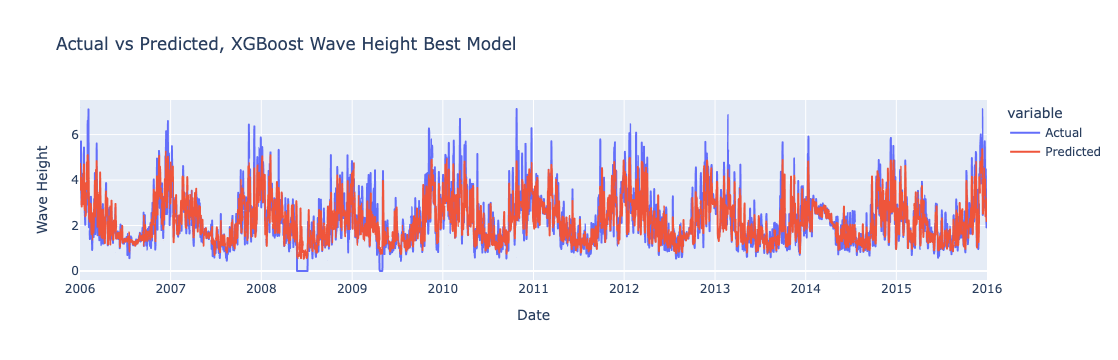

In [186]:
#plot predictions vs actual 
X_test_wh.index = pd.to_datetime(X_test_wh.index)

# Create a DataFrame with actual and predicted values
plot_data = pd.DataFrame({'Datetime': X_test_wh.index, 'Actual': y_test_wh, 'Predicted': y_pred_xg_wh2})

# Plotly line plot
fig = px.line(plot_data, x='Datetime', y=['Actual', 'Predicted'], title='Actual vs Predicted, XGBoost Wave Height Best Model',
              labels={'value': 'Wave Height', 'Datetime': 'Date'}, line_shape='linear')

# Show the plot
fig.show()

### Random Forest

In [44]:
#Pipeline
rf_pipeline = Pipeline([
    ('rf_model', RandomForestRegressor(random_state=42))
])

**Random Forest, GridSearch 1, Identifier: 'rf_base_opt_wh'**

In [45]:
#param grid
param_grid_rf = {
    'rf_model__n_estimators': [50, 100, 200],
    'rf_model__max_depth': [None, 5, 10],
    'rf_model__min_samples_split': [2, 5, 10],
    'rf_model__min_samples_leaf': [1, 2, 4],
}

In [47]:
scoring_metric = 'neg_mean_squared_error'
results_gridsearch_rf = run_grid_search(X_train_wh, y_train_wh, param_grid_rf, rf_pipeline, scoring_metric, 'rf_base_opt_wh')

Best Parameters for rf_base_opt_wh: {'rf_model__max_depth': None, 'rf_model__min_samples_leaf': 4, 'rf_model__min_samples_split': 2, 'rf_model__n_estimators': 200}
Best neg_mean_squared_error Score for rf_base_opt_wh: -0.27120182240137547
Elapsed Time for rf_base_opt_wh: 1749.7028198242188 seconds


In [48]:
#evaluate best model 
y_pred_rf_wh, mse_rf_wh, mae_rf_wh = evaluate_model(results_gridsearch_rf.best_estimator_, X_test_wh, y_test_wh)


Mean Squared Error: 0.2531974938558
Mean Absolute Error: 0.36200631558507973


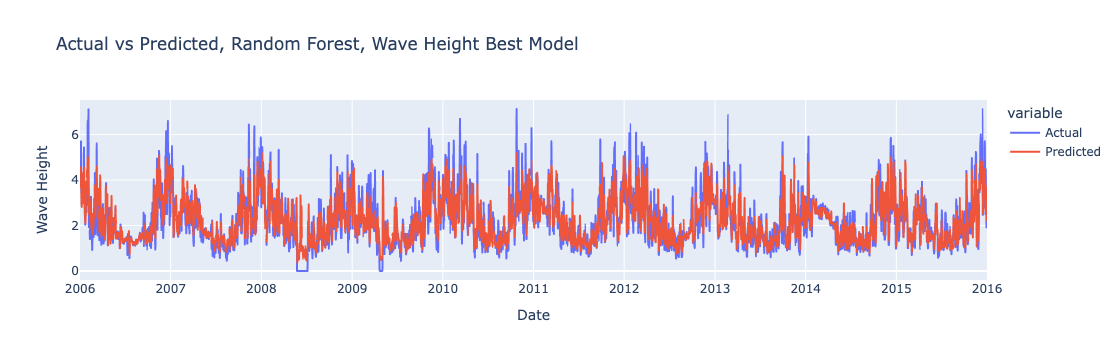

In [49]:
#plot predictions vs actual 
X_test_wh.index = pd.to_datetime(X_test_wh.index)

# Create a DataFrame with actual and predicted values
plot_data = pd.DataFrame({'Datetime': X_test_wh.index, 'Actual': y_test_wh, 'Predicted': y_pred_rf_wh})

# Plotly line plot
fig = px.line(plot_data, x='Datetime', y=['Actual', 'Predicted'], title='Actual vs Predicted, Random Forest, Wave Height Best Model',
              labels={'value': 'Wave Height', 'Datetime': 'Date'}, line_shape='linear')

# Show the plot
fig.show()

### Results Wave Height: 
Wave height predicted without current wave period

# Wave Period

In [122]:
# Define lags for different time intervals
lags = {'1_day': 1, '1_week': 7, '1_month': 30, '3_month': 90}


# Create a new DataFrame to avoid modifying the original DataFrame in place
new_df_wp = pd.DataFrame()

# Create lags
for column in df.select_dtypes(include='number').columns:
    # Create lags for different time intervalsa
    for lag_name, lag_value in lags.items():
        new_df_wp[f'{column}_lag_{lag_name}'] = df[column].shift(lag_value)


# Combine the new features with the original DataFrame
features_df_wp = pd.concat([df, new_df_wp], axis=1)

# Drop rows with null values
features_df_wp = features_df_wp.dropna()

# Display the modified DataFrame
print(features_df_wp.head())


               LATITUDE  LONGITUDE  DEPTH      VWH$      VCMX       VTP$  \
Datetime_buoy                                                              
1989-02-20        48.83      126.0   73.0  2.000417  3.683333  12.922500   
1989-02-21        48.83      126.0   73.0  2.281739  3.926087  13.330435   
1989-02-22        48.83      126.0   73.0  2.645000  4.691667  10.620833   
1989-02-23        48.83      126.0   73.0  2.488750  4.337500  10.010000   
1989-02-24        48.83      126.0   73.0  2.564583  4.475000  12.950833   

                   WDIR       WSPD       GSPD    WDIR.1  ...  \
Datetime_buoy                                            ...   
1989-02-20     2.070397   9.537500  11.558333  1.914772  ...   
1989-02-21     2.057971  10.847826  13.182609  1.891026  ...   
1989-02-22     2.600541   8.416667  10.287500  2.431098  ...   
1989-02-23     2.953970   5.193750   6.987500  2.781618  ...   
1989-02-24     1.845686   5.983333   7.516667  1.693697  ...   

               DMD

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/276038429.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/276038429.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/276038429.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [123]:
#drop features for wave period dataframe: 
col_to_drop_wp = ['VCMX','HS','ETTSea','ETOT','ETTSw','VWH$','TPSea','TP','TPSw','TPSea','MO1','MO2']
wp_df = features_df_wp.drop(columns=col_to_drop_wp)

In [124]:
wp_df.index = pd.to_datetime(wp_df.index)

In [125]:
#Create cyclical encoded features for month, season, and week
wp_df['month_sin'] = np.sin(2 * np.pi * wp_df.index.month / 12)
wp_df['month_cos'] = np.cos(2 * np.pi * wp_df.index.month / 12)

#Assume seasons are defined as quarters (1-4)
wp_df['season_sin'] = np.sin(2 * np.pi * wp_df.index.month % 12 / 4)
wp_df['season_cos'] = np.cos(2 * np.pi * wp_df.index.month % 12 / 4)

wp_df['week_sin'] = np.sin(2 * np.pi * wp_df.index.strftime('%U').astype(int) / 52)  # Assuming 52 weeks in a year
wp_df['week_cos'] = np.cos(2 * np.pi * wp_df.index.strftime('%U').astype(int) / 52)


/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/2899335625.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/2899335625.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/2899335625.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [126]:
wp_df['moon_phase'] = wp_df.index.map(get_moon_phase)

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/2431433676.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [127]:
#cyclic encode the moonphase as it is ordinal, then drop moon phase
wp_df['moon_phase_sin'] = np.sin(2 * np.pi * wp_df['moon_phase'] / 8)
wp_df['moon_phase_cos'] = np.cos(2 * np.pi * wp_df['moon_phase'] / 8)

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/3111445164.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h5/pnqm5hvd2vj1397_ck_gmtj00000gn/T/ipykernel_91605/3111445164.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [128]:
wp_df=wp_df.drop('moon_phase', axis=1)

In [129]:
wp_df.shape

(9812, 162)

### Linear Regression

In [130]:
#split on date for train and test
split_point = '2006-01-01'
#filter data on split point
train_wp= wp_df.index < split_point
test_wp = wp_df.index >= split_point

In [131]:
#define X and y
X_train_wp = wp_df[train_wp].drop(['VTP$'],axis=1)
y_train_wp = wp_df[train_wp]['VTP$']

X_test_wp = wp_df[test_wp].drop(['VTP$'], axis=1)
y_test_wp = wp_df[test_wp]['VTP$']

In [132]:
X_train_wp.shape

(6159, 161)

In [133]:
#PCA and Scale
pca = PCA(n_components=0.95)
scaler = StandardScaler()
#fit and transform to train X, transform test X
X_train_wp_pca = pca.fit_transform(scaler.fit_transform(X_train_wp))
X_test_wp_pca = pca.transform(scaler.transform(X_test_wp))

MSE Wave Period: 3.0436719233787155
MAE Wave Period: 1.343607051501229


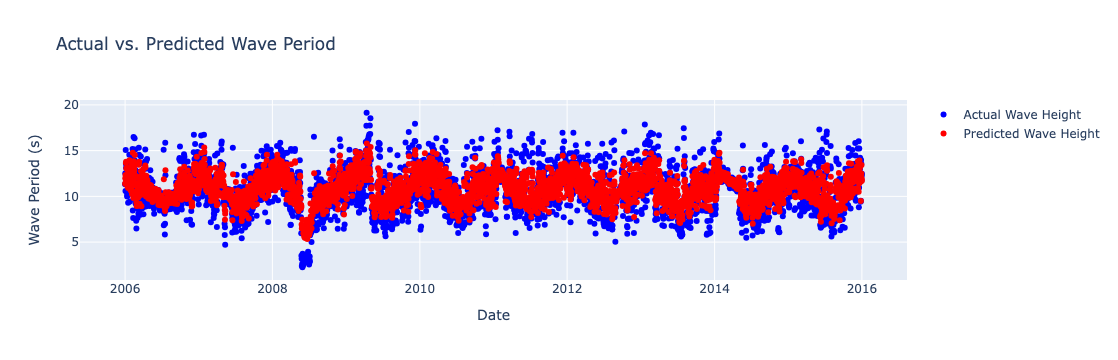

In [138]:
#Linear Regression
model_linreg_wp = LinearRegression()
model_linreg_wp.fit(X_train_wp_pca, y_train_wp)

#Predict
y_wp_pred = model_linreg_wp.predict(X_test_wp_pca)

#Calculate MSE and MAE
mse_wp = mean_squared_error(y_test_wp,y_wp_pred)
mae_wp = mean_absolute_error(y_test_wp,y_wp_pred)
#Print MSE and MAE
print("MSE Wave Period:", mse_wp)
print("MAE Wave Period:", mae_wp)

#Plot Linear Reg. with predictions and acutal values
#plt.figure(figsize=(15, 6))
#plt.scatter(features_df.index[test_wh], y_test_wh, label='Actual Wave Height', color='blue')
#plt.scatter(features_df.index[test_wh], y_wh_pred, label='Predicted Wave Height', color='red')
#plt.xlabel('Date')
#plt.ylabel('Wave Height')
#plt.legend()
#plt.title('Actual vs. Predicted Wave Height/Period')
#plt.show()

#Scatter plot for Actual Wave Height
actual_trace = go.Scatter(x=features_df.index[test_wp], y=y_test_wp, mode='markers', name='Actual Wave Height', marker=dict(color='blue'))

#Scatter plot for Predicted Wave Height
predicted_trace = go.Scatter(x=features_df.index[test_wp], y=y_wp_pred, mode='markers', name='Predicted Wave Height', marker=dict(color='red'))

#Create the layout
layout = go.Layout(
    title='Actual vs. Predicted Wave Period',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Wave Period (s)'),
    showlegend=True
)

#Create figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)
fig.show()

In [135]:
scaler = StandardScaler()
X_train_lasso_wp = scaler.fit_transform(X_train_wp)
X_test_lasso_wp = scaler.transform(X_test_wp) 

In [136]:
#use for loop to optimize for alpha value 
alpha_vals= [0.001,0.01,0.1,1,10]

best_alpha= None
best_mse = float('inf')

#iterate through alpha values
for alpha in alpha_vals:
    #fit lasso model
    lasso =Lasso(alpha=alpha)
    lasso.fit(X_train_lasso_wp, y_train_wp)

    #predict
    y_pred_lasso_wp = lasso.predict(X_test_lasso_wp)
    #MSE
    mse = mean_squared_error(y_test_wp,y_pred_lasso_wp)

    #check if current alpha gives a better mse
    if mse < best_mse:
        best_mse = mse
        best_alpha =alpha

print(f'Best Alpha:{best_alpha}')
print(f'Best MSE: {best_mse}')

final_lasso_wp = Lasso(alpha=best_alpha)
final_lasso_wp.fit(X_train_lasso_wp, y_train_wp)


/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e+02, tolerance: 3.308e+00



Best Alpha:0.001
Best MSE: 2.903418480073459


/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e+02, tolerance: 3.308e+00



Lasso(alpha=0.001)

Feature: WSPD.1, Coefficient: -1.9179994862980116
Feature: GSPD.1, Coefficient: 1.9088132297851914
Feature: WSPD, Coefficient: -1.2671377915083006
Feature: VTP$_lag_1_day, Coefficient: 0.9876444088766406
Feature: GSPD, Coefficient: 0.8697594218325914
Feature: WSPD_lag_1_day, Coefficient: 0.6009049759029681
Feature: MO2_lag_1_day, Coefficient: -0.4663767903018738
Feature: GSPD_lag_1_day, Coefficient: -0.42261789719049864
Feature: HS_lag_1_day, Coefficient: 0.3867340850644353
Feature: WSPD_lag_1_month, Coefficient: 0.33183794565476427
Feature: week_cos, Coefficient: 0.3316633677953438
Feature: GSPD_lag_1_month, Coefficient: -0.2976994100670873
Feature: month_sin, Coefficient: 0.21837756072719883
Feature: MO2_lag_1_week, Coefficient: -0.2130919121784849
Feature: GSPD.1_lag_1_month, Coefficient: -0.19890735541588483
Feature: YEAR, Coefficient: -0.19495323881724955
Feature: WSPD.1_lag_1_month, Coefficient: 0.18701744237845716
Feature: WD, Coefficient: -0.18575087302232596
Feature: WSPD.1_la

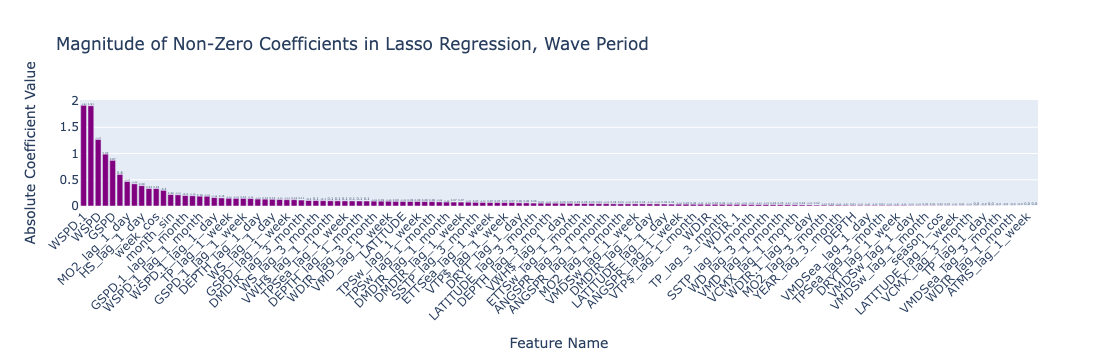

In [169]:
coefficients_lasso_wp = final_lasso_wp.coef_
original_feature_names_wp = X_train_wp.columns.tolist()

# Identify non-zero coefficients and their corresponding feature names
non_zero_indices_wp = np.nonzero(coefficients_lasso_wp)[0]
non_zero_feature_names_wp = [original_feature_names_wp[i] for i in non_zero_indices_wp]
non_zero_coefficients_wp = coefficients_lasso_wp[non_zero_indices_wp]

# Create a list of tuples containing feature names and coefficients
feature_coefficient_pairs_wp = list(zip(non_zero_feature_names_wp, non_zero_coefficients_wp))

# Sort the list based on the absolute values of coefficients in descending order
sorted_feature_coefficient_pairs_wp = sorted(feature_coefficient_pairs_wp, key=lambda x: abs(x[1]), reverse=True)

# Print the sorted list
for feature, coefficient in sorted_feature_coefficient_pairs_wp:
    print(f'Feature: {feature}, Coefficient: {coefficient}')

# Plotly bar plot for non-zero feature names and coefficients
fig = go.Figure()

fig.add_trace(go.Bar(
    x=[pair[0] for pair in sorted_feature_coefficient_pairs_wp],
    y=[abs(pair[1]) for pair in sorted_feature_coefficient_pairs_wp],
    marker_color='purple',
    text=[round(pair[1], 2) for pair in sorted_feature_coefficient_pairs_wp],
    textposition='outside'
))

fig.update_layout(
    title='Magnitude of Non-Zero Coefficients in Lasso Regression, Wave Period',
    xaxis_title='Feature Name',
    yaxis_title='Absolute Coefficient Value',
    xaxis_tickangle=-45,
    showlegend=False
)

fig.show()


### Ensemble Learning

### XGBoost
- Base param grid will be used for initial optimization (base_param_grid)
- Same Pipeline and gridsearch function as with wave height

#Param Grid
- param_grid_gbtree = {
    - 'xgb_model__booster': ['gbtree'],
    - 'xgb_model__learning_rate': [0.01, 0.1, 0.2],
    - 'xgb_model__max_depth': [3, 5, 7],
    - 'xgb_model__n_estimators': [50, 100, 200],
}

#Param grid for gblinear booster
 - param_grid_gblinear = {
    - 'xgb_model__booster': ['gblinear'],
    - 'xgb_model__learning_rate': [0.01, 0.1, 0.2],
    - 'xgb_model__reg_alpha': [0, 0.1, 0.5],
}


base_param_grid =[param_grid_gbtree, param_grid_gblinear]

**XGBoost Wave Period, Gridsearch 1, Identifier: 'xg_base_opt_wp'**


In [139]:
scoring_metric = 'neg_mean_squared_error'
results_gridsearch_wp = run_grid_search(X_train_wp, y_train_wp, base_param_grid, xgb_pipeline, scoring_metric, 'xg_base_opt_wp')

/Users/kamiasalango/anaconda3/envs/capstone_wavepower/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Parameters for xg_base_opt_wp: {'xgb_model__booster': 'gbtree', 'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 3, 'xgb_model__n_estimators': 100}
Best neg_mean_squared_error Score for xg_base_opt_wp: -3.5746085446881146
Elapsed Time for xg_base_opt_wp: 38.96059536933899 seconds


In [140]:
#evaluate best model 
y_pred_xg_wp1, mse_xg_wp1, mae_xg_wp1 = evaluate_model(results_gridsearch_wp.best_estimator_, X_test_wp, y_test_wp)


Mean Squared Error: 3.069107801608883
Mean Absolute Error: 1.3193360973850818


**XGBoost Wave Period, Gridsearch 2, Identifier: 'xg_opt_wp'**


In [150]:
#Param Grid
param_grid_gbtree_wp = {
    'xgb_model__booster': ['gbtree'],
    'xgb_model__learning_rate': [0.01, 0.1, 0.2],
    'xgb_model__max_depth': [3, 5, 7, 8], 
    'xgb_model__n_estimators': [75, 100, 150], #tune n_estimators around 100 
}

In [151]:
scoring_metric = 'neg_mean_squared_error'
results_gridsearch_wp2 = run_grid_search(X_train_wp, y_train_wp, param_grid_gbtree_wp, xgb_pipeline, scoring_metric, 'xg_base_opt_wp')

Best Parameters for xg_base_opt_wp: {'xgb_model__booster': 'gbtree', 'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 3, 'xgb_model__n_estimators': 100}
Best neg_mean_squared_error Score for xg_base_opt_wp: -3.5746085446881146
Elapsed Time for xg_base_opt_wp: 69.67576599121094 seconds


In [155]:
#evaluate best model 
y_pred_xg_wp2, mse_xg_wp2, mae_xg_wp2 = evaluate_model(results_gridsearch_wp2.best_estimator_, X_test_wp, y_test_wp)


Mean Squared Error: 3.069107801608883
Mean Absolute Error: 1.3193360973850818


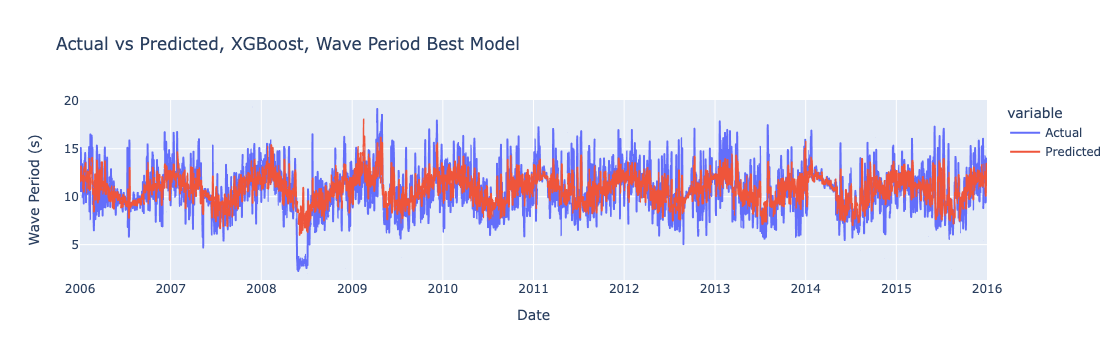

In [168]:
#Plot predictions for best model -> y_test_wp1
#plot predictions vs actual 
X_test_wp.index = pd.to_datetime(X_test_wp.index)

# Create a DataFrame with actual and predicted values
plot_data = pd.DataFrame({'Datetime': X_test_wp.index, 'Actual': y_test_wp, 'Predicted': y_pred_xg_wp2})

# Plotly line plot
fig = px.line(plot_data, x='Datetime', y=['Actual', 'Predicted'], title='Actual vs Predicted, XGBoost, Wave Period Best Model',
              labels={'value': 'Wave Period (s)', 'Datetime': 'Date'}, line_shape='linear')

# Show the plot
fig.show()

### Random Forest
- Same Pipeline as wave height and same param grid for wave height will be used for initial optimization. 

**RF Wave Period, GridSearch 1, Identifier: 'optimize_rf_wp'**

In [154]:
#Grid Search
scoring_metric = 'neg_mean_squared_error'
grid_search_rf_wp = run_grid_search(X_train_wp, y_train_wp, param_grid_rf, rf_pipeline, scoring_metric, 'optimize_rf_wp')

Best Parameters for optimize_rf_wp: {'rf_model__max_depth': None, 'rf_model__min_samples_leaf': 4, 'rf_model__min_samples_split': 10, 'rf_model__n_estimators': 200}
Best neg_mean_squared_error Score for optimize_rf_wp: -3.6604461669837676
Elapsed Time for optimize_rf_wp: 1796.3950321674347 seconds


In [156]:
#evaluate best model 
y_pred_rf_wp, mse_rf_wp, mae_rf_wp = evaluate_model(results_gridsearch_wp2.best_estimator_, X_test_wp, y_test_wp)


Mean Squared Error: 3.069107801608883
Mean Absolute Error: 1.3193360973850818


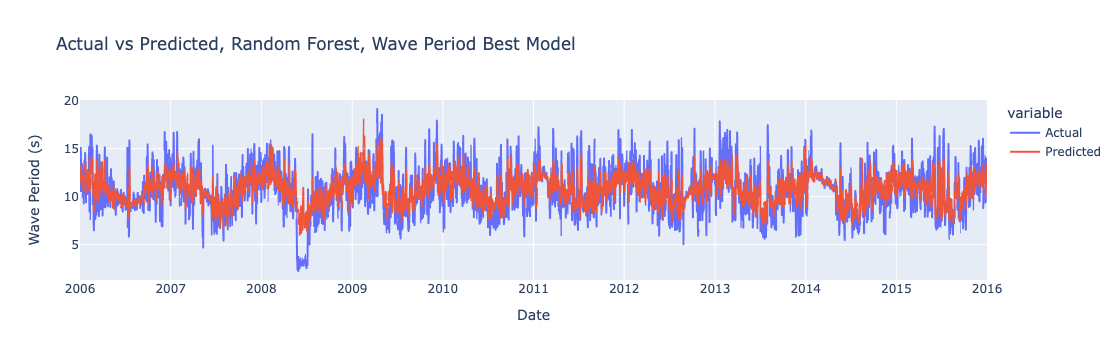

In [163]:
#Plot predictions for best model -> y_test_wp1
#plot predictions vs actual 
X_test_wp.index = pd.to_datetime(X_test_wp.index)

# Create a DataFrame with actual and predicted values
plot_data = pd.DataFrame({'Datetime': X_test_wp.index, 'Actual': y_test_wp, 'Predicted': y_pred_rf_wp})

# Plotly line plot
fig = px.line(plot_data, x='Datetime', y=['Actual', 'Predicted'], title='Actual vs Predicted, Random Forest, Wave Period Best Model',
              labels={'value': 'Wave Period (s)', 'Datetime': 'Date'}, line_shape='linear')

# Show the plot
fig.show()

# Results

In [159]:
results_df = pd.DataFrame(results_list)

In [162]:
results_df

identifier                                        best_params  \
0  xg_base_opt_wh  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
1       xg_opt_wh  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
2  rf_base_opt_wh  {'rf_model__max_depth': None, 'rf_model__min_s...   
3  xg_base_opt_wh  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
4  xg_base_opt_wp  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
5  xg_base_opt_wp  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
6  xg_base_opt_wp  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
7  xg_base_opt_wp  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
8  xg_base_opt_wp  {'xgb_model__booster': 'gbtree', 'xgb_model__l...   
9  optimize_rf_wp  {'rf_model__max_depth': None, 'rf_model__min_s...   

   best_score  elapsed_time  
0   -0.244112     40.990956  
1   -0.244112     60.875815  
2   -0.271202   1749.702820  
3   -0.241372     40.725749  
4   -3.574609     38.960595  
5   -3.549064    114.003154  
6   -3.574609    110.972520  
7   -3.599033    113.468099  
8   -3.574609     69.675766  
9   -3.660446   1796.395032

XGBoost models and Random Forest could both be further tuned for wave height and wave period, however the range for decrease in error for wave height was not found to be more than 0.03 meters and the range for decresase in error for wave period was not more than 0.03 seconds. Summary of the test scores for models for both wave height and wave period is displayed below: 

Note: ARIMA model included for reference, since ARIMA is univariate both features could be forecasted simultaneously.

| Model              | Wave Period (MSE) | Wave Period (MAE - seconds) | Wave Height (MSE) | Wave Height (MAE - meters) |
| ------------------ | ------------------ | ---------------------------- | ----------------- | --------------------------- |
| Random Forest      | 3.069             | 1.319                        | 0.253             | 0.362                       |
| XGBoost            | 3.069             | 1.319                        | 0.232             | 0.345                       |
| Linear Regression  | 3.043             | 1.343                        | 0.307             | 0.391                       |
| ARIMA              | 6.94              | 2.06                         | 1.47              | 0.91                        |


The results for error for wave period are fairly close between the three models, XGBoost and Random Forest have the best performance. Both could be further optimized to find out which produces the lowest error however for this analysis an error difference of 1 second would be benificial and the error range seems to fluctuate within milliseconds. The results for wave height also show small difference in error reductions. The best performing model for predicting wave height is XGBoost, with gbtree as booster.  

**Feature Analysis**
Based on the Lasso Regression for feature analysis, in predicting wave height and wave period separately feature values on forecasted day relating to wave period were left in for wave height and feature values on forecasted day relating to wave height were left in for wave period. In this notebook Features were reassessed and feature values for current forecast window relating to wave height and wave period were dropped for both forecasts. There was an increase in error which is discussed further in the conclusion,  however the increase in error was not enough to make wave height forecast fall outside of error range of 2 feet and the error increase in wave period fell within the millisecond range for mean absolute error. The feature importance affecting forecast as seen in Lasso Regressions changed. Features of importance for wave height and wave period were as follows: 

**Wave Height and Period (coefficients above 0.19)**

| Wave Height Feature   | Coefficient          |   | Wave Period Feature   | Coefficient          |
|------------------------|----------------------|---|------------------------|----------------------|
| WSPD.1                 | -1.825               |   | WSPD.1                 | -1.918               |
| GSPD.1                 | 1.787                |   | GSPD.1                 | 1.909                |
| WSPD                   | -1.331               |   | WSPD                   | -1.267               |
| MO2                    | 1.319                |   | VTP$_lag_1_day         | 0.988                |
| GSPD                   | 0.976                |   | GSPD                   | 0.870                |
| VTP$$_lag_1_day        | 0.965                |   | WSPD_lag_1_day         | 0.601                |
| WSPD_lag_1_day         | 0.696                |   | MO2_lag_1_day          | -0.466               |
| MO2_lag_1_day          | -0.597               |   | GSPD_lag_1_day         | -0.423               |
| MO1                    | -0.585               |   | HS_lag_1_day           | 0.387                |
| GSPD_lag_1_day         | -0.577               |   | WSPD_lag_1_month       | 0.332                |
| WS                     | -0.466               |   | week_cos               | 0.332                |
| HS_lag_1_day           | 0.391                |   | GSPD_lag_1_month       | -0.298               |
| week_cos               | 0.341                |   | month_sin              | 0.218                |
| WSPD_lag_1_month       | 0.335                |   | MO2_lag_1_week         | -0.213               |
| GSPD_lag_1_month       | -0.295               |   |                        |                      |
| MO2_lag_1_week         | -0.229               |   |                        |                      |
| YEAR                   | -0.218               |   |                        |                      |
| month_sin              | 0.206                |   |                        |                      |
| GSPD.1_lag_1_month     | -0.203               |   |                        |                      |


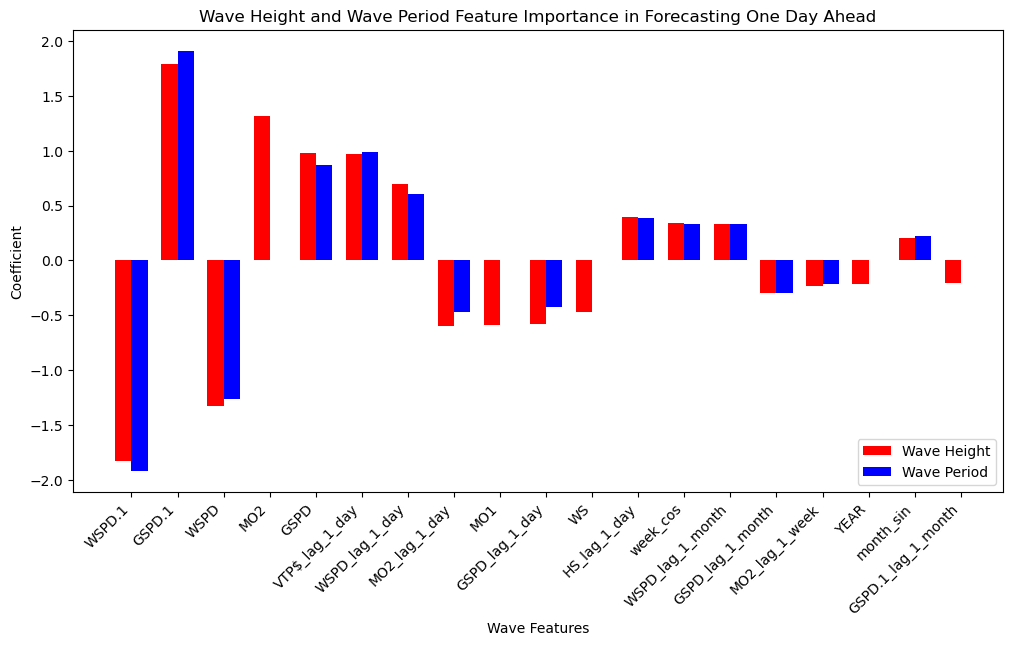

In [185]:
# Data for the two tables
data_wave_height = {
    "Wave Height Feature": ["WSPD.1", "GSPD.1", "WSPD", "MO2", "GSPD", "VTP$_lag_1_day", "WSPD_lag_1_day", "MO2_lag_1_day", "MO1", "GSPD_lag_1_day", "WS", "HS_lag_1_day", "week_cos", "WSPD_lag_1_month", "GSPD_lag_1_month", "MO2_lag_1_week", "YEAR", "month_sin", "GSPD.1_lag_1_month"],
    "Coefficient_height": [-1.825, 1.787, -1.331, 1.319, 0.976, 0.965, 0.696, -0.597, -0.585, -0.577, -0.466, 0.391, 0.341, 0.335, -0.295, -0.229, -0.218, 0.206, -0.203]
}

data_wave_period = {
    "Wave Period Feature": ["WSPD.1", "GSPD.1", "WSPD", "VTP$_lag_1_day", "GSPD", "WSPD_lag_1_day", "MO2_lag_1_day", "GSPD_lag_1_day", "HS_lag_1_day", "WSPD_lag_1_month", "week_cos", "GSPD_lag_1_month", "month_sin", "MO2_lag_1_week"],
    "Coefficient_period": [-1.918, 1.909, -1.267, 0.988, 0.870, 0.601, -0.466, -0.423, 0.387, 0.332, 0.332, -0.298, 0.218, -0.213]
}

# Convert data to DataFrames
df_wave_height = pd.DataFrame(data_wave_height)
df_wave_period = pd.DataFrame(data_wave_period)

# Create a combined DataFrame
df_combined = pd.merge(df_wave_height, df_wave_period, how='outer', left_on='Wave Height Feature', right_on='Wave Period Feature', suffixes=('_height', '_period'))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
bar_positions_height = np.arange(len(df_combined))
bar_positions_period = bar_positions_height + bar_width

ax.bar(bar_positions_height, df_combined['Coefficient_height'], bar_width, label='Wave Height', color='red')
ax.bar(bar_positions_period, df_combined['Coefficient_period'], bar_width, label='Wave Period', color='blue')

ax.set_xticks(bar_positions_height + bar_width / 2)
ax.set_xticklabels(df_combined['Wave Height Feature'], rotation=45, ha='right')

ax.set_xlabel('Wave Features')
ax.set_ylabel('Coefficient')
ax.set_title('Wave Height and Wave Period Feature Importance in Forecasting One Day Ahead')
ax.legend()

plt.show()


From these tables, current wind speed, gust speed, and estimations of wind speed are important features in forecasting both wave height and wave period. The lags of these features are also contributing to the forecasted prediction. Wind direction however has a lower coefficient value followed by some of its lags. Wind speed and direction is important in surf forecasting, understanding the feature importance of Wind speed and direction and lags may be helpful in including wind as another forecast component. Perhaps only one or the other will be included to reduce an increase in errors in forecasting. Also wave period lag of one day appears of importance in forecasting wave height for the next day and for forecasting wave period for the next day. Wave height lags do not show as much importance in forecasting either wave height or wave period. Further and more insightful feature analysis may be done by feature extraction from best performing models. 

# Summary

The results from the forecast of wave height and wave period for same time window can now be compared to the results of wave height and wave period forecasted seperately. 

**Wave Height and Wave Period Forecasted Independently**
| Model              | Wave Period (MSE) | Wave Period (MAE - seconds) | Wave Height (MSE) | Wave Height (MAE - meters) |
| ------------------ | ------------------ | ---------------------------- | ----------------- | --------------------------- |
| Random Forest      | 2.90              | 1.25                         | 0.015             | 0.067                       |
| XGBoost            | 2.80              | 1.22                         | 0.017             | 0.071                       |
| Linear Regression  | 2.83              | 1.28                         | 0.19              | 0.31                        |
| ARIMA              | 6.94              | 2.06                         | 1.47              | 0.91                        |


**Wave Height and Wave Period Forecasted Simultaneously for same time window**
| Model              | Wave Period (MSE) | Wave Period (MAE - seconds) | Wave Height (MSE) | Wave Height (MAE - meters) |
| ------------------ | ------------------ | ---------------------------- | ----------------- | --------------------------- |
| Random Forest      | 3.069             | 1.319                        | 0.253             | 0.362                       |
| XGBoost            | 3.069             | 1.319                        | 0.232             | 0.345                       |
| Linear Regression  | 3.043             | 1.343                        | 0.307             | 0.391                       |
| ARIMA              | 6.94              | 2.06                         | 1.47              | 0.91                        |


In comparing results from wave height and wave period forecasted seperately with wave period and wave height forecasted for the same time window the error overall increased for wave period and wave height forecasted together. In comparing the best models, the error increased by: 
- Wave Period error: 
    - mse: 0.269
    - mae: 0.099 seconds
- Wave Height error:
    - mse: 0.217
    - mae: 0.278 meters

# Conclusion/ Next Steps

Wave height and wave peiod can be forecasted in conjuction for the same forecast window without a large increase in error relative to the purpose of this analysis. The MAE from XGBoost, the best performing model is about 1.13 feet, which is smaller than the error range of 2 feet that was given as the benchmark for this analysis. There is no benchmark comparison for wave period, however the error of about 1.32 seconds relative to surf forecasting is not large as it does not usually differentiate between ground swell and wind swell. It is also important to note that for ensemble modelling the test mse and mae scores were larger than the train, the scores however were close, this may be due to overfitting of models and another iteration may be performed to assess this. The next steps of this project are to explore Vector AutoRegression in forecasting Wave height and Wave Period for same time frame as well as Neural Networks. Other important components of a surf forecast such as swell direction and wind speed and direction will also be incorporated. It is important to note that as more components are forecasted error increases so exploring different methodologies to forecasting these components will be considered. Possible solution to this may lay in assessing feature relationships further and using the best model to forecast each component and perhaps include the live forecast of one component in forecasting another, constructing a sequential forecast. Another area of direction for this project will also be to experiment with different forecast windows as well incorporating bathymettry data pertaining to wave height and period as waves approach shore.  The main goal is to develop this project into a live forecast that takes in live buoy data and incorporates local bathymetry data using machine learning and generates a usable surf forecast for a specific region.  There is also the idea of developing a live forecast where surfers can choose which component they would like to be the most accurate based on personal preference. In conclusion the project thusfar demonstrates that two main components of a surf forecast can be both be predicted for the same time window(one day) with a lower error range than the error range of 2 feet for wave height and within 1.31 seconds for wave period. 